In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import time
import astropy.units as u
import astropy.constants as c

In [2]:
def save_image_to_fits(L_ARRg,B_ARRg,
                       L_ARR,B_ARR,
                       dOmega,dOmega_unit,
                       pixelsize,pixel_unit,
                       image,flux_unit,
                       filename='filename.fits',
                       overwrite=True,
                       comments=[]):

    from astropy import wcs
    import datetime
    from astropy.io import fits
    
    wcs = wcs.WCS(naxis=2)
    nx = L_ARR.shape[1]
    ny = B_ARR.shape[0]
    pixscalelon = pixelsize # cdelt1
    pixscalelat = pixelsize  # cdelt2

    idx_l_select = int(nx/2)
    idx_b_select = int(ny/2)


    wcs.wcs.crpix = [idx_l_select+0.5,idx_b_select+0.5] # Ref pixel for axis 1 and 2
    # the 0.5 is important so that the map fits the coordinate grid!!!
    wcs.wcs.cdelt = np.array([pixscalelon, pixscalelat]) # what is the pixel scale in lon, lat.
    wcs.wcs.crval = [L_ARRg[0,idx_l_select],B_ARRg[idx_b_select,0]]  #what is the galactic coordinate of that pixel.
    wcs.wcs.ctype = ["GLON-CAR", "GLAT-CAR"] #CAR projection #AIT projection
    
    today = datetime.date.today()
    
    header = wcs.to_header()
    header['history'] = "Thomas Siegert created this file on "+str(today)+" " 
    header['EXTNAME'] = "IMAGE"
    
    # total flux in iamge
    total_flux = np.sum(image*dOmega)
    header['FLUX'] = str(total_flux)
    header['FLUXUNIT'] = str(flux_unit).strip('/'+str(dOmega_unit))
    
    header['DOMEGA'] = dOmega_unit
    header['PIX_UNIT'] = pixel_unit
    
    for comment in comments:
        header['COMMENT'] = comment
    
    # define header
    hdu_image = fits.ImageHDU(image,header=header)
    
    # define auxiliary things
    lon_bounds_header = fits.Header()
    lon_bounds_header['EXTNAME'] = 'LON_BNDS'
    longitude_boundaries = fits.ImageHDU(data=L_ARRg,header=lon_bounds_header)
    
    lat_bounds_header = fits.Header()
    lat_bounds_header['EXTNAME'] = 'LAT_BNDS'
    latitude_boundaries = fits.ImageHDU(data=B_ARRg,header=lat_bounds_header)
    
    lon_cen_header = fits.Header()
    lon_cen_header['EXTNAME'] = 'LON_CENT'
    longitude_centers = fits.ImageHDU(data=L_ARR,header=lon_cen_header)
    
    lat_cen_header = fits.Header()
    lat_cen_header['EXTNAME'] = 'LAT_CENT'
    latitude_centers = fits.ImageHDU(data=B_ARR,header=lat_cen_header)

    # define pixel solid angle areas
    dOmega_header = fits.Header()
    dOmega_header['EXTNAME'] = 'D_OMEGA'
    dOmega_values = fits.ImageHDU(data=dOmega,header=dOmega_header)

    # primary header (no info)
    primary_hdu = fits.PrimaryHDU()
    
    # list of entries
    hdul = fits.HDUList([primary_hdu,
                         hdu_image,
                         longitude_boundaries,
                         latitude_boundaries,
                         longitude_centers,
                         latitude_centers,
                         dOmega_values])
    
    # save file
    hdul.writeto(filename, overwrite=overwrite)

In [3]:
binsize = 1.0
lmin, lmax = -180, 180
bmin, bmax = -90, 90
deg2rad = np.pi/180
n_l = int((lmax-lmin)/binsize)
n_b = int((bmax-bmin)/binsize)
bg = np.linspace(bmin, bmax, n_b+1)
lg = np.linspace(lmin, lmax, n_l+1)
b = (bg[1:]+bg[0:-1])/2
l = (lg[1:]+lg[0:-1])/2
L_ARRg, B_ARRg = np.meshgrid(lg, bg)
L_ARR, B_ARR = np.meshgrid(l, b)
domega = (binsize*deg2rad)*(np.sin(np.deg2rad(B_ARR+binsize/2)) - np.sin(np.deg2rad(B_ARR-binsize/2)))

In [4]:
np.sum(domega),4*np.pi

(12.566370614359174, 12.566370614359172)

<h3>511 keV model map</h3>

In [5]:
def Gaussian2D(l,b,p):
    A = p[0]
    l0 = p[1]
    sl = p[2]
    b0 = p[3]
    sb = p[4]
    val = p[0]*np.exp(-0.5*(l-l0)**2/sl**2 -0.5*(b-b0)**2/sb**2)
    return val

In [6]:
# disk
F_disk = 1.7e-3
l0_disk = 0
b0_disk = 0
sl_disk = 60
sb_disk = 10.5

par_disk = [1.,l0_disk,sl_disk,b0_disk,sb_disk]

map_disk = Gaussian2D(L_ARR,B_ARR,par_disk)

# renorm
map_disk = map_disk/np.sum(map_disk*domega)*F_disk

# check flux
print(np.sum(map_disk*domega))

0.0017


In [7]:
# BB
F_BB = 7.3e-4
l0_BB = 0
b0_BB = 0
sl_BB = 8.7
sb_BB = 8.7

par_BB = [1.,l0_BB,sl_BB,b0_BB,sb_BB]

map_BB = Gaussian2D(L_ARR,B_ARR,par_BB)

# renorm
map_BB = map_BB/np.sum(map_BB*domega)*F_BB

# check flux
print(np.sum(map_BB*domega))

0.00073


In [8]:
# NB
F_NB = 2.8e-4
l0_NB = -1.15
b0_NB = -0.25
sl_NB = 2.5
sb_NB = 2.5

par_NB = [1.,l0_NB,sl_NB,b0_NB,sb_NB]

map_NB = Gaussian2D(L_ARR,B_ARR,par_NB)

# renorm
map_NB = map_NB/np.sum(map_NB*domega)*F_NB

# check flux
print(np.sum(map_NB*domega))

0.00028


In [9]:
# GCS
F_GCS = 8.2e-5
l0_GCS = -0.06
b0_GCS = -0.05
sl_GCS = 1.3
sb_GCS = 1.3

par_GCS = [1.,l0_GCS,sl_GCS,b0_GCS,sb_GCS]

map_GCS = Gaussian2D(L_ARR,B_ARR,par_GCS)

# renorm
map_GCS = map_GCS/np.sum(map_GCS*domega)*F_GCS

# check flux
print(np.sum(map_GCS*domega))

8.200000000000001e-05


In [10]:
map_tot = map_disk + map_BB + map_NB + map_GCS*1
print(np.sum(map_tot*domega))

0.0027919999999999993


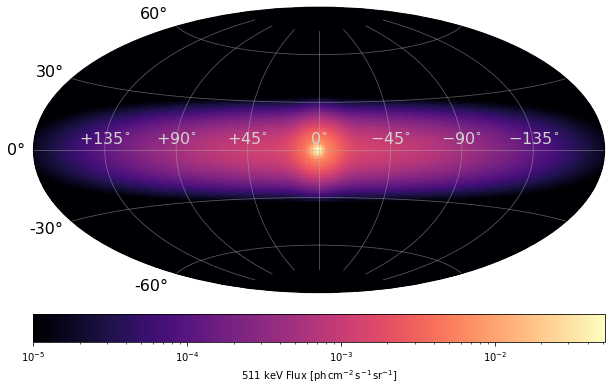

In [11]:
plt.figure(figsize=(10.24,7.68))
plt.subplot(projection='aitoff')
plt.pcolormesh(L_ARRg*deg2rad,B_ARRg*deg2rad,map_tot,
               norm=colors.LogNorm(vmin=1e-5),rasterized=True,cmap=plt.cm.magma)
plt.colorbar(orientation='horizontal',
             label=r'511 keV Flux [$\mathrm{ph\,cm^{-2}\,s^{-1}\,sr^{-1}}$]',
             pad=0.05)

plt.xticks(np.array([135,90,45,0,-45,-90,-135])*deg2rad,
           labels=[r'$-135^{\circ}$',
                   r'$-90^{\circ}$',
                   r'$-45^{\circ}$',
                   r'$0^{\circ}$',
                   r'$+45^{\circ}$',
                   r'$+90^{\circ}$',
                   r'$+135^{\circ}$'],
           color='lightgray',fontsize=16)
plt.yticks(np.array([-60,-30,0,30,60])*deg2rad,fontsize=16)
plt.grid(alpha=0.5)

In [12]:
save_image_to_fits(L_ARRg,B_ARRg,
                   L_ARR,B_ARR,
                   domega,'sr',
                   1,'deg',
                   np.flip(map_tot,axis=1),'ph/s/cm2/sr',
                   filename='MW_Siegert2016_511.fits',
                   overwrite=True,
                   comments=[])